In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [114]:
public_bill = calc.public_bill
public_bill

2640560

In [115]:
_public_bill = public_bill / len(month_df)
_public_bill

24449.62962962963

# 히스토그램 그룹화

<AxesSubplot:>

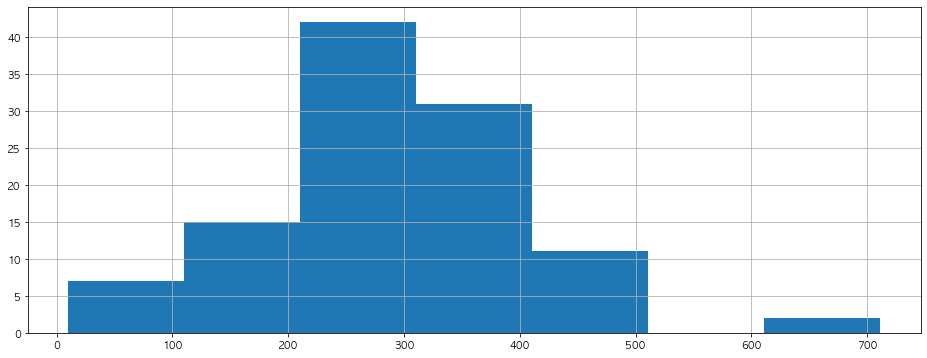

In [9]:
bins = round(mt.sqrt(len(month_df) / 2))

month_df['usage (kWh)'].hist(bins=bins, figsize=(16,6))

In [24]:
y, x = np.histogram(month_df['usage (kWh)'].values, bins=bins)
hist_df = pd.DataFrame(columns=['start', 'end', '가구 수'])

for idx, _x in enumerate(x[:-1]):
    _y = y[idx]
    
    start = _x
    end = x[idx + 1]
    
    hist_df = hist_df.append({
        "start": start,
        "end": end,
        "가구 수": _y
    }, ignore_index=True)
    
hist_df

,start,end,가구 수
0,10.000000,110.142857,7.0
1,110.142857,210.285714,15.0
2,210.285714,310.428571,42.0
3,310.428571,410.571429,31.0
4,410.571429,510.714286,11.0
5,510.714286,610.857143,0.0
6,610.857143,711.000000,2.0


In [45]:
groups = np.array([])

for usage in month_df['usage (kWh)']:
    chk = []
    
    for idx, row in hist_df.iterrows():
        start = row['start']
        end = row['end']
        
        chk.append((usage >= start) and (usage <= end))

    group_num = np.where(chk)[0][0]
    groups = np.append(groups, group_num).astype("int")
    
month_df['그룹 번호'] = groups
month_df.head(10)

,name,usage (kWh),그룹 번호
0,아파트1-101-1002,253,2
1,아파트1-101-104,689,6
2,아파트1-101-1102,183,1
3,아파트1-101-1202,239,2
4,아파트1-101-1302,455,4
5,아파트1-101-1401,343,3
6,아파트1-101-1403,380,3
7,아파트1-101-1502,219,2
8,아파트1-101-1504,389,3
9,아파트1-101-1602,350,3


# 기여도 산정

In [40]:
cont_df = month_df.copy()

In [41]:
# 방법 1. 그룹의 중간값으로 기여도 산정
# 방법 1-1. 그룹의 중간값들의 합을 통해 기여도 산정
# 방법 2-1. 중간값과 세대부 총 사용량을 비교

In [42]:
# 방법 2. 그룹안에 속해있는 가구들의 사용량 총합으로 기여도 산정

## 방법 1. 그룹의 중간값으로 기여도 산정

In [49]:
medians = []

for idx, row in hist_df.iterrows():
    start = row['start']
    end = row['end']
    
    medians.append((start + end) / 2)
    
hist_df['median'] = medians
hist_df

,start,end,가구 수,median
0,10.000000,110.142857,7.0,60.071429
1,110.142857,210.285714,15.0,160.214286
2,210.285714,310.428571,42.0,260.357143
3,310.428571,410.571429,31.0,360.500000
4,410.571429,510.714286,11.0,460.642857
5,510.714286,610.857143,0.0,560.785714
6,610.857143,711.000000,2.0,660.928571


### 방법 1-1. 그룹의 중간값들의 합을 통해 기여도 산정

In [123]:
cont_df_1_1 = month_df.copy()
hist_df_1_1 = hist_df.copy()

median_total = hist_df['median'].sum()
hist_df_1_1['contribution'] = hist_df_1_1['median'] / median_total
hist_df_1_1

,start,end,가구 수,median,contribution
0,10.000000,110.142857,7.0,60.071429,0.023805
1,110.142857,210.285714,15.0,160.214286,0.063489
2,210.285714,310.428571,42.0,260.357143,0.103173
3,310.428571,410.571429,31.0,360.500000,0.142857
4,410.571429,510.714286,11.0,460.642857,0.182541
5,510.714286,610.857143,0.0,560.785714,0.222225
6,610.857143,711.000000,2.0,660.928571,0.261909


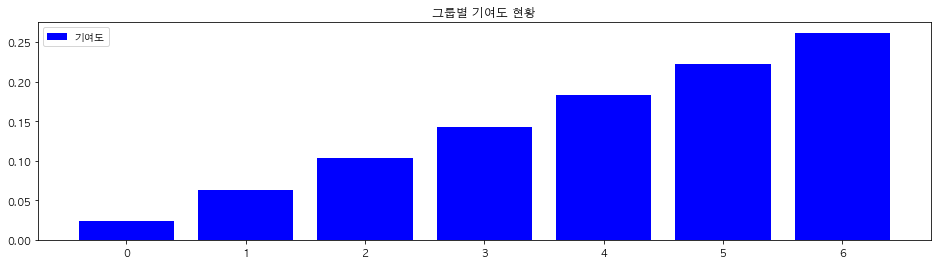

In [124]:
plt.figure(figsize=(16,4))

plt.bar(range(len(hist_df)), hist_df_1_1['contribution'], color='b', label='기여도')
plt.title("그룹별 기여도 현황")
plt.legend()

plt.show()

### 방법 1-2. 중간값과 세대부 총 사용량을 비교

In [125]:
cont_df_1_2 = month_df.copy()
cont_df_1_2['contribution'] = 0
households_total = month_df['usage (kWh)'].sum()

for idx, median in enumerate(hist_df['median']):
    cont = median / households_total
    print(cont)
    cont_df_1_2['contribution'][cont_df_1_2['그룹 번호'] == idx] = cont
    
cont_df_1_2.head(10)

0.0019313087889476779
0.005150922251616697
0.008370535714285716
0.011590149176954733
0.01480976263962375
0.018029376102292768
0.02124898956496179


,name,usage (kWh),그룹 번호,contribution
0,아파트1-101-1002,253,2,0.008371
1,아파트1-101-104,689,6,0.021249
2,아파트1-101-1102,183,1,0.005151
3,아파트1-101-1202,239,2,0.008371
4,아파트1-101-1302,455,4,0.014810
5,아파트1-101-1401,343,3,0.011590
6,아파트1-101-1403,380,3,0.011590
7,아파트1-101-1502,219,2,0.008371
8,아파트1-101-1504,389,3,0.011590
9,아파트1-101-1602,350,3,0.011590


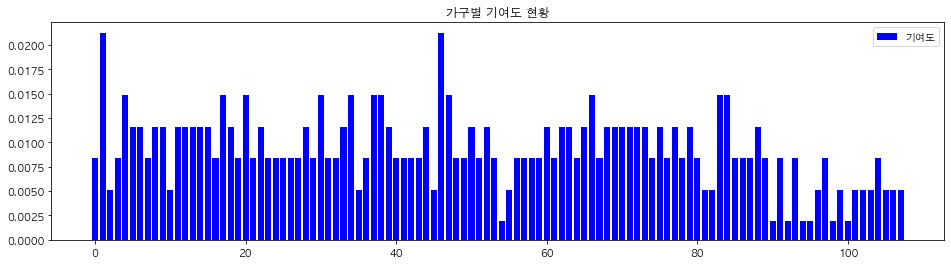

In [126]:
plt.figure(figsize=(16,4))

plt.bar(range(len(month_df)), cont_df_1_2['contribution'], color='b', label='기여도')
plt.title("가구별 기여도 현황")
plt.legend()

plt.show()

## 방법 2. 그룹안에 속해있는 가구들의 사용량 총합으로 기여도 산정

In [101]:
cont_df_2 = month_df.copy()
cont_df_2['contribution'] = 0
hist_df_2 = hist_df.copy()
total_usages = []

for idx in hist_df_2.index:
    total_usage = cont_df_2[cont_df_2['그룹 번호'] == idx]['usage (kWh)'].sum()
    total_usages.append(total_usage)
    
hist_df_2['사용량 총 합'] = total_usages
hist_df_2

,start,end,가구 수,median,사용량 총 합
0,10.000000,110.142857,7.0,60.071429,315
1,110.142857,210.285714,15.0,160.214286,2551
2,210.285714,310.428571,42.0,260.357143,10768
3,310.428571,410.571429,31.0,360.500000,11154
4,410.571429,510.714286,11.0,460.642857,4916
5,510.714286,610.857143,0.0,560.785714,0
6,610.857143,711.000000,2.0,660.928571,1400


In [108]:
cont_df_2 = hist_df_2.copy()
cont_df_2['contribution'] = cont_df_2['사용량 총 합'] / households_total

cont_df_2

,start,end,가구 수,median,사용량 총 합,contribution
0,10.000000,110.142857,7.0,60.071429,315,0.010127
1,110.142857,210.285714,15.0,160.214286,2551,0.082015
2,210.285714,310.428571,42.0,260.357143,10768,0.346193
3,310.428571,410.571429,31.0,360.500000,11154,0.358603
4,410.571429,510.714286,11.0,460.642857,4916,0.158050
5,510.714286,610.857143,0.0,560.785714,0,0.000000
6,610.857143,711.000000,2.0,660.928571,1400,0.045010


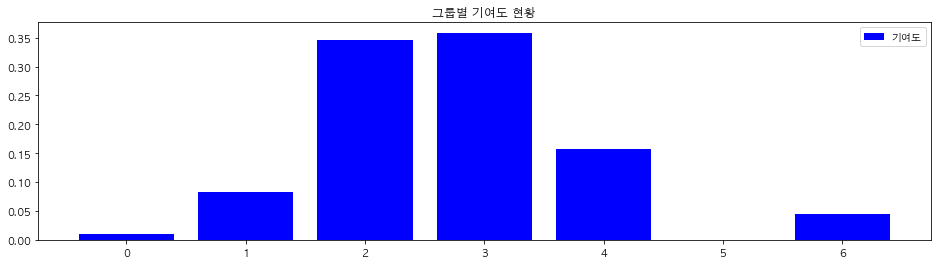

In [109]:
plt.figure(figsize=(16,4))

plt.bar(range(len(cont_df_2)), cont_df_2['contribution'], color='b', label='기여도')
plt.title("그룹별 기여도 현황")
plt.legend()

plt.show()

# 단순 가격분배

## 그룹의 중간값을 이용한 기여도 산정

### 그룹의 중간값들의 토탈과 비교하여 기여도 산정

In [142]:
simple_hist_1_1 = hist_df_1_1.copy()
simple_hist_1_1 = simple_hist_1_1[hist_df_1_1['가구 수'] > 0]

simple_hist_1_1['단순 가격분배'] = round(public_bill * simple_cont_1_1['contribution']).astype("int")
simple_hist_1_1['가구 별 분배 가격'] = (simple_hist_1_1['단순 가격분배'] / simple_hist_1_1['가구 수']).round().astype("int")

simple_hist_1_1.head(10)

,start,end,가구 수,median,contribution,단순 가격분배,가구 별 분배 가격
0,10.000000,110.142857,7.0,60.071429,0.023805,62858,8980
1,110.142857,210.285714,15.0,160.214286,0.063489,167646,11176
2,210.285714,310.428571,42.0,260.357143,0.103173,272435,6487
3,310.428571,410.571429,31.0,360.500000,0.142857,377223,12168
4,410.571429,510.714286,11.0,460.642857,0.182541,482011,43819
6,610.857143,711.000000,2.0,660.928571,0.261909,691588,345794


In [158]:
simple_cont_1_1 = month_df.copy()
simple_cont_1_1['단순 가격분배'] = 0

for idx, row in simple_hist_1_1.iterrows():
    public_fee = row['가구 별 분배 가격']
    simple_cont_1_1['단순 가격분배'][simple_cont_1_1['그룹 번호'] == idx] = public_fee
    
simple_cont_1_1['공용부 요금 나머지'] = round((public_bill - simple_cont_1_1['단순 가격분배'].sum()) / len(simple_cont_1_1))
simple_cont_1_1['최종 공용부 요금'] = simple_cont_1_1['단순 가격분배'] + simple_cont_1_1['공용부 요금 나머지']
    
simple_cont_1_1.head(10)

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
0,아파트1-101-1002,253,2,6487,5433,11920
1,아파트1-101-104,689,6,345794,5433,351227
2,아파트1-101-1102,183,1,11176,5433,16609
3,아파트1-101-1202,239,2,6487,5433,11920
4,아파트1-101-1302,455,4,43819,5433,49252
5,아파트1-101-1401,343,3,12168,5433,17601
6,아파트1-101-1403,380,3,12168,5433,17601
7,아파트1-101-1502,219,2,6487,5433,11920
8,아파트1-101-1504,389,3,12168,5433,17601
9,아파트1-101-1602,350,3,12168,5433,17601


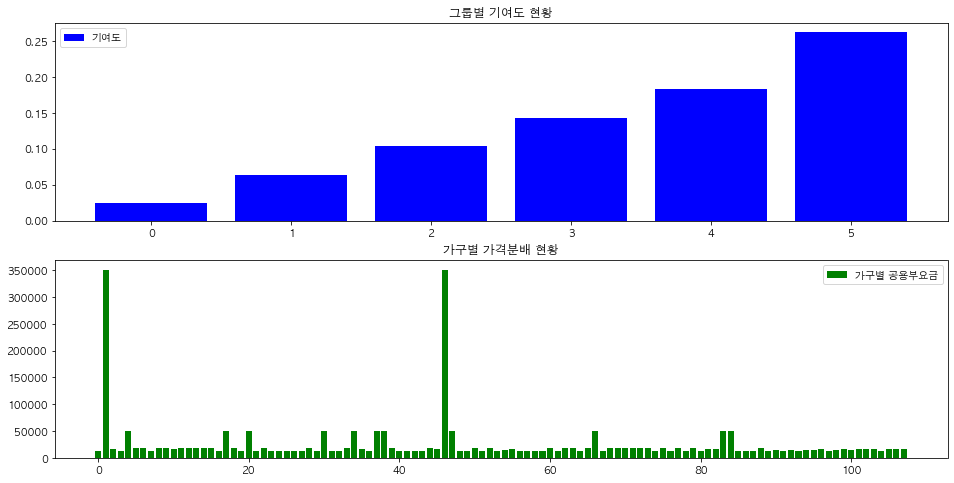

In [161]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(simple_hist_1_1)), simple_hist_1_1['contribution'], color='b', label='기여도')
ax_1.set_title("그룹별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), simple_cont_1_1['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [162]:
min_h = simple_cont_1_1[simple_cont_1_1['name'] == '아파트1-104-905']
mean_h = simple_cont_1_1[simple_cont_1_1['name'] == '아파트1-102-801']
max_h = simple_cont_1_1[simple_cont_1_1['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
107,아파트1-104-905,148,1,11176,5433,16609
43,아파트1-102-801,280,2,6487,5433,11920
46,아파트1-102-903,711,6,345794,5433,351227


### 세대부 총 사용량과 비교하여 기여도 산정

In [179]:
simple_cont_1_2 = cont_df_1_2.copy()
simple_cont_1_2['단순 가격분배'] = round(public_bill * simple_cont_1_2['contribution']).astype("int")
simple_cont_1_2['공용부 요금 나머지'] = round((public_bill - simple_cont_1_2['단순 가격분배'].sum()) / len(month_df))
simple_cont_1_2['최종 공용부 요금'] = (simple_cont_1_2['단순 가격분배'] + simple_cont_1_2['공용부 요금 나머지']).round().astype("int")

simple_cont_1_2.head(10)

,name,usage (kWh),그룹 번호,contribution,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
0,아파트1-101-1002,253,2,0.008371,22103,-172,21931
1,아파트1-101-104,689,6,0.021249,56109,-172,55937
2,아파트1-101-1102,183,1,0.005151,13601,-172,13429
3,아파트1-101-1202,239,2,0.008371,22103,-172,21931
4,아파트1-101-1302,455,4,0.014810,39106,-172,38934
5,아파트1-101-1401,343,3,0.011590,30604,-172,30432
6,아파트1-101-1403,380,3,0.011590,30604,-172,30432
7,아파트1-101-1502,219,2,0.008371,22103,-172,21931
8,아파트1-101-1504,389,3,0.011590,30604,-172,30432
9,아파트1-101-1602,350,3,0.011590,30604,-172,30432


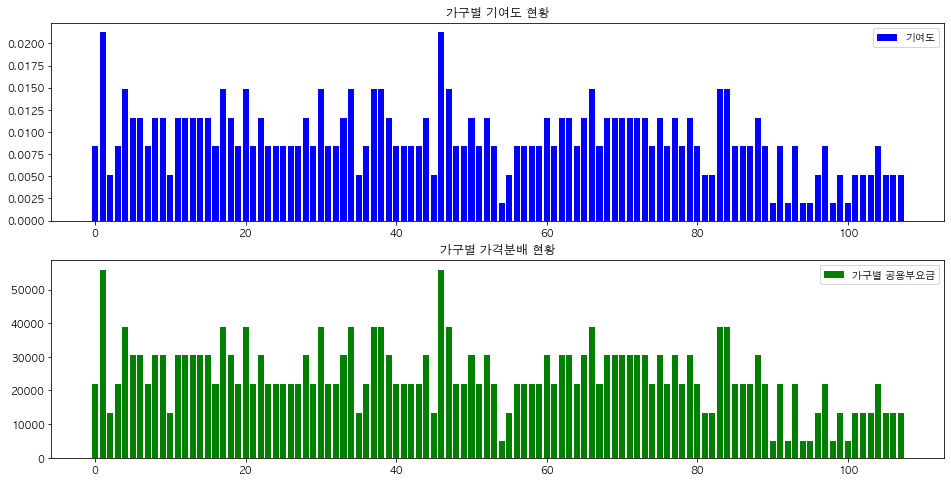

In [180]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(month_df)), simple_cont_1_2['contribution'], color='b', label='기여도')
ax_1.set_title("가구별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), simple_cont_1_2['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [181]:
min_h = simple_cont_1_2[simple_cont_1_2['name'] == '아파트1-104-905']
mean_h = simple_cont_1_2[simple_cont_1_2['name'] == '아파트1-102-801']
max_h = simple_cont_1_2[simple_cont_1_2['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,contribution,단순 가격분배,공용부 요금 나머지,최종 공용부 요금
107,아파트1-104-905,148,1,0.005151,13601,-172,13429
43,아파트1-102-801,280,2,0.008371,22103,-172,21931
46,아파트1-102-903,711,6,0.021249,56109,-172,55937


## 그룹안에 속해있는 가구들의 사용량 총합으로 기여도 산정

In [201]:
simple_hist_2 = cont_df_2.copy()
simple_hist_2 = simple_hist_2[cont_df_2['가구 수'] > 0]

simple_hist_2['단순 가격분배'] = round(public_bill * cont_df_2['contribution']).astype("int")
simple_hist_2['가구 별 분배 가격'] = (simple_hist_2['단순 가격분배'] / simple_hist_2['가구 수']).round().astype("int")

simple_hist_2

,start,end,가구 수,median,사용량 총 합,contribution,단순 가격분배,가구 별 분배 가격
0,10.000000,110.142857,7.0,60.071429,315,0.010127,26742,3820
1,110.142857,210.285714,15.0,160.214286,2551,0.082015,216566,14438
2,210.285714,310.428571,42.0,260.357143,10768,0.346193,914144,21765
3,310.428571,410.571429,31.0,360.500000,11154,0.358603,946914,30546
4,410.571429,510.714286,11.0,460.642857,4916,0.158050,417342,37940
6,610.857143,711.000000,2.0,660.928571,1400,0.045010,118852,59426


In [212]:
simple_cont_2 = month_df.copy()
simple_cont_2['단순 가격분배'] = 0

for idx, row in simple_hist_2.iterrows():
    simple_cont_2['단순 가격분배'][simple_cont_2['그룹 번호'] == idx] = row['가구 별 분배 가격']

simple_cont_2.head(10)

,name,usage (kWh),그룹 번호,단순 가격분배
0,아파트1-101-1002,253,2,21765
1,아파트1-101-104,689,6,59426
2,아파트1-101-1102,183,1,14438
3,아파트1-101-1202,239,2,21765
4,아파트1-101-1302,455,4,37940
5,아파트1-101-1401,343,3,30546
6,아파트1-101-1403,380,3,30546
7,아파트1-101-1502,219,2,21765
8,아파트1-101-1504,389,3,30546
9,아파트1-101-1602,350,3,30546


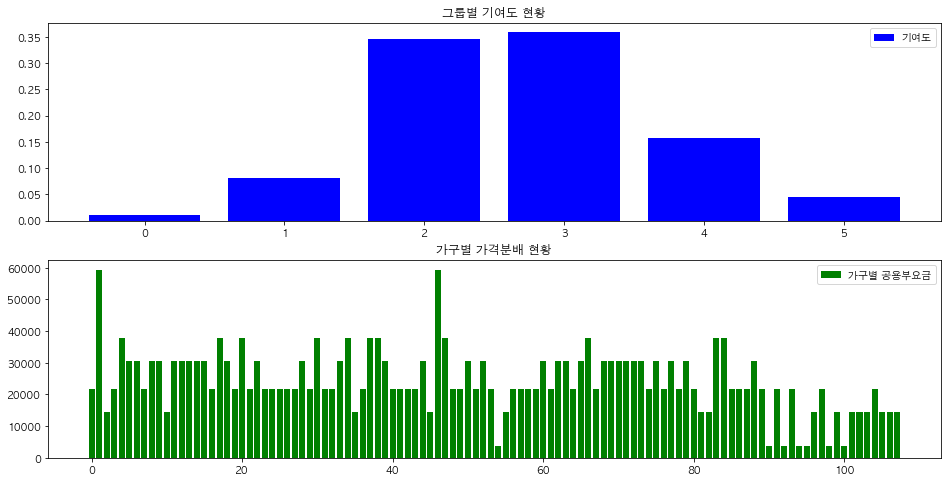

In [210]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(simple_hist_2)), simple_hist_2['contribution'], color='b', label='기여도')
ax_1.set_title("그룹별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), simple_cont_2['단순 가격분배'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [211]:
min_h = simple_cont_2[simple_cont_2['name'] == '아파트1-104-905']
mean_h = simple_cont_2[simple_cont_2['name'] == '아파트1-102-801']
max_h = simple_cont_2[simple_cont_2['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,단순 가격분배
107,아파트1-104-905,148,1,14438
43,아파트1-102-801,280,2,21765
46,아파트1-102-903,711,6,59426


# 기여도 공용부요금

In [228]:
# 예측 시뮬레이션
pp = PublicPredictor(
    APT=APT,
    month_df=month_df[['name', 'usage (kWh)']],
    month=_month
)
pp.predict

실제 요금    2640560
예측 요금    2639700
오차           860
dtype: int64

## 그룹의 중간값을 이용한 기여도 산정

### 그룹의 중간값들의 토탈과 비교하여 기여도 산정 

In [250]:
dist_1_1 = hist_df_1_1.copy()
dist_1_1 = dist_1_1[dist_1_1['가구 수'] > 0]

dist_1_1['기여도 공용부 기본요금'] = (pp.basic * dist_1_1['contribution']).round().astype("int")
dist_1_1['기여도 공용부 전력량요금'] = (pp.elec_rate * dist_1_1['contribution']).round().astype("int")
dist_1_1['기여도 공용부 요금'] = dist_1_1['기여도 공용부 기본요금'] + dist_1_1['기여도 공용부 전력량요금']
dist_1_1['가구 별 분배가격'] = (dist_1_1['기여도 공용부 요금'] / dist_1_1['가구 수']).round().astype("int")

dist_1_1

,start,end,가구 수,median,contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부 요금,가구 별 분배가격
0,10.000000,110.142857,7.0,60.071429,0.023805,10931,42662,53593,7656
1,110.142857,210.285714,15.0,160.214286,0.063489,29153,113783,142936,9529
2,210.285714,310.428571,42.0,260.357143,0.103173,47376,184904,232280,5530
3,310.428571,410.571429,31.0,360.500000,0.142857,65599,256025,321624,10375
4,410.571429,510.714286,11.0,460.642857,0.182541,83821,327146,410967,37361
6,610.857143,711.000000,2.0,660.928571,0.261909,120266,469387,589653,294826


In [251]:
dist_cont_1_1 = month_df.copy()
dist_cont_1_1['기여도 공용부 요금'] = 0

for idx, row in dist_1_1.iterrows():
    public_fee = row['가구 별 분배가격']
    dist_cont_1_1['기여도 공용부 요금'][simple_cont_1_1['그룹 번호'] == idx] = public_fee
    
dist_cont_1_1['공용부 요금 나머지'] = round((public_bill - dist_cont_1_1['기여도 공용부 요금'].sum()) / len(dist_cont_1_1))
dist_cont_1_1['최종 공용부 요금'] = dist_cont_1_1['기여도 공용부 요금'] + dist_cont_1_1['공용부 요금 나머지']
    
dist_cont_1_1.head(10)

,name,usage (kWh),그룹 번호,기여도 공용부 요금,공용부 요금 나머지,최종 공용부 요금
0,아파트1-101-1002,253,2,5530,8236,13766
1,아파트1-101-104,689,6,294826,8236,303062
2,아파트1-101-1102,183,1,9529,8236,17765
3,아파트1-101-1202,239,2,5530,8236,13766
4,아파트1-101-1302,455,4,37361,8236,45597
5,아파트1-101-1401,343,3,10375,8236,18611
6,아파트1-101-1403,380,3,10375,8236,18611
7,아파트1-101-1502,219,2,5530,8236,13766
8,아파트1-101-1504,389,3,10375,8236,18611
9,아파트1-101-1602,350,3,10375,8236,18611


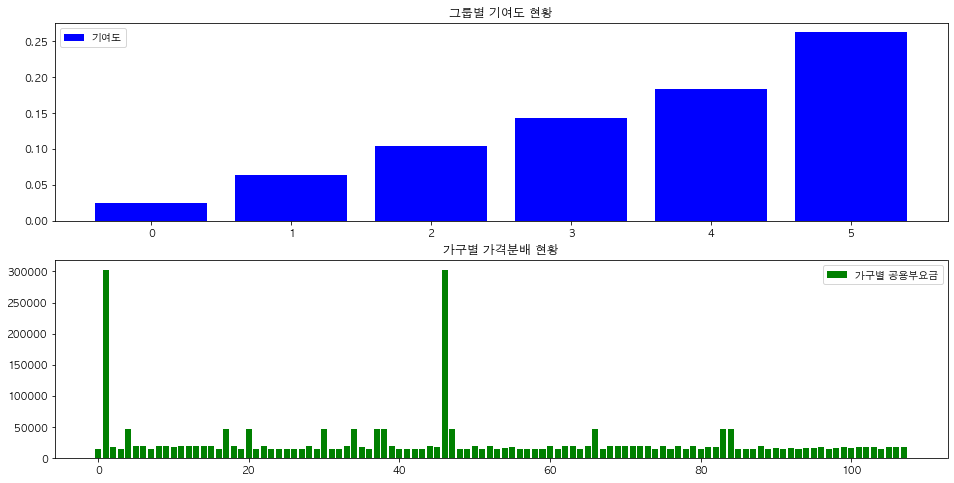

In [252]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(dist_1_1)), dist_1_1['contribution'], color='b', label='기여도')
ax_1.set_title("그룹별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), dist_cont_1_1['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [253]:
min_h = dist_cont_1_1[dist_cont_1_1['name'] == '아파트1-104-905']
mean_h = dist_cont_1_1[dist_cont_1_1['name'] == '아파트1-102-801']
max_h = dist_cont_1_1[dist_cont_1_1['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,기여도 공용부 요금,공용부 요금 나머지,최종 공용부 요금
107,아파트1-104-905,148,1,9529,8236,17765
43,아파트1-102-801,280,2,5530,8236,13766
46,아파트1-102-903,711,6,294826,8236,303062


### 세대부 총 사용량과 비교하여 기여도 산정

In [254]:
dist_cont_1_2 = cont_df_1_2.copy()

dist_cont_1_2['기여도 공용부 기본요금'] = round(pp.basic * dist_cont_1_2['contribution']).astype("int")
dist_cont_1_2['기여도 공용부 전력량요금'] = round(pp.elec_rate * dist_cont_1_2['contribution']).astype("int")
dist_cont_1_2['기여도 공용부 요금'] = dist_cont_1_2['기여도 공용부 기본요금'] + dist_cont_1_2['기여도 공용부 전력량요금']
dist_cont_1_2['공용부 요금 나머지'] = round((public_bill - dist_cont_1_2['기여도 공용부 요금'].sum()) / len(month_df))
dist_cont_1_2['최종 공용부 요금'] = dist_cont_1_2['기여도 공용부 요금'] + dist_cont_1_2['공용부 요금 나머지']

dist_cont_1_2.head(10)

,name,usage (kWh),그룹 번호,contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부 요금,공용부 요금 나머지,최종 공용부 요금
0,아파트1-101-1002,253,2,0.008371,3844,15001,18845,3457,22302
1,아파트1-101-104,689,6,0.021249,9757,38082,47839,3457,51296
2,아파트1-101-1102,183,1,0.005151,2365,9231,11596,3457,15053
3,아파트1-101-1202,239,2,0.008371,3844,15001,18845,3457,22302
4,아파트1-101-1302,455,4,0.014810,6800,26542,33342,3457,36799
5,아파트1-101-1401,343,3,0.011590,5322,20772,26094,3457,29551
6,아파트1-101-1403,380,3,0.011590,5322,20772,26094,3457,29551
7,아파트1-101-1502,219,2,0.008371,3844,15001,18845,3457,22302
8,아파트1-101-1504,389,3,0.011590,5322,20772,26094,3457,29551
9,아파트1-101-1602,350,3,0.011590,5322,20772,26094,3457,29551


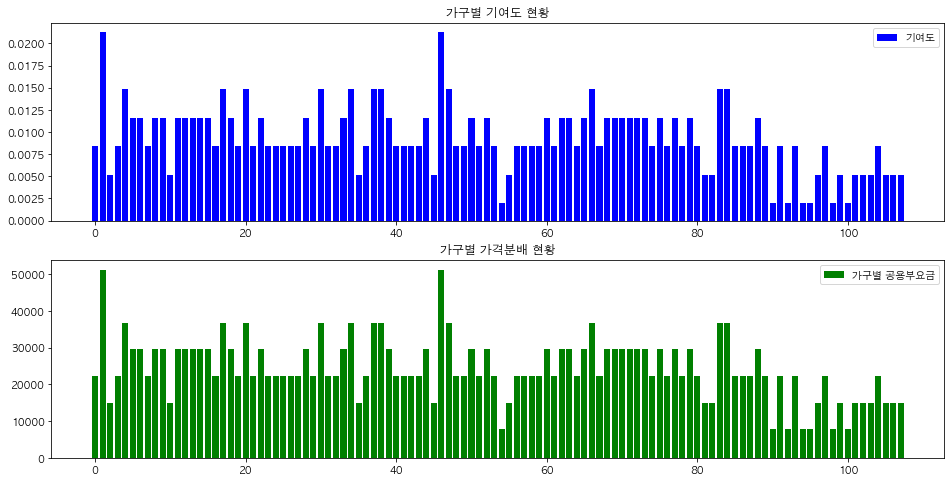

In [255]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(month_df)), dist_cont_1_2['contribution'], color='b', label='기여도')
ax_1.set_title("가구별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), dist_cont_1_2['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [256]:
min_h = dist_cont_1_2[dist_cont_1_2['name'] == '아파트1-104-905']
mean_h = dist_cont_1_2[dist_cont_1_2['name'] == '아파트1-102-801']
max_h = dist_cont_1_2[dist_cont_1_2['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부 요금,공용부 요금 나머지,최종 공용부 요금
107,아파트1-104-905,148,1,0.005151,2365,9231,11596,3457,15053
43,아파트1-102-801,280,2,0.008371,3844,15001,18845,3457,22302
46,아파트1-102-903,711,6,0.021249,9757,38082,47839,3457,51296


## 그룹안에 속해있는 가구들의 사용량 총합으로 기여도 산정

In [260]:
dist_2 = cont_df_2.copy()
dist_2 = dist_2[cont_df_2['가구 수'] > 0]

dist_2['기여도 공용부 기본요금'] = round(pp.basic * dist_2['contribution']).astype("int")
dist_2['기여도 공용부 전력량요금'] = round(pp.elec_rate * dist_2['contribution']).astype("int")
dist_2['기여도 공용부 요금'] = dist_2['기여도 공용부 기본요금'] + dist_2['기여도 공용부 전력량요금']
dist_2['가구 별 분배가격'] = (dist_2['기여도 공용부 요금'] / dist_2['가구 수']).round().astype("int")

dist_2

,start,end,가구 수,median,사용량 총 합,contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부 요금,가구 별 분배가격
0,10.000000,110.142857,7.0,60.071429,315,0.010127,4650,18150,22800,3257
1,110.142857,210.285714,15.0,160.214286,2551,0.082015,37661,146985,184646,12310
2,210.285714,310.428571,42.0,260.357143,10768,0.346193,158969,620439,779408,18557
3,310.428571,410.571429,31.0,360.500000,11154,0.358603,164667,642680,807347,26043
4,410.571429,510.714286,11.0,460.642857,4916,0.158050,72575,283254,355829,32348
6,610.857143,711.000000,2.0,660.928571,1400,0.045010,20668,80666,101334,50667


In [261]:
dist_cont_2 = month_df.copy()
dist_cont_2['기여도 공용부 요금'] = 0

for idx, row in dist_2.iterrows():
    public_fee = row['가구 별 분배가격']
    dist_cont_2['기여도 공용부 요금'][simple_cont_2['그룹 번호'] == idx] = public_fee
    
dist_cont_2['공용부 요금 나머지'] = round((public_bill - dist_cont_2['기여도 공용부 요금'].sum()) / len(dist_cont_2))
dist_cont_2['최종 공용부 요금'] = dist_cont_2['기여도 공용부 요금'] + dist_cont_2['공용부 요금 나머지']
    
dist_cont_2.head(10)

,name,usage (kWh),그룹 번호,기여도 공용부 요금,공용부 요금 나머지,최종 공용부 요금
0,아파트1-101-1002,253,2,18557,3604,22161
1,아파트1-101-104,689,6,50667,3604,54271
2,아파트1-101-1102,183,1,12310,3604,15914
3,아파트1-101-1202,239,2,18557,3604,22161
4,아파트1-101-1302,455,4,32348,3604,35952
5,아파트1-101-1401,343,3,26043,3604,29647
6,아파트1-101-1403,380,3,26043,3604,29647
7,아파트1-101-1502,219,2,18557,3604,22161
8,아파트1-101-1504,389,3,26043,3604,29647
9,아파트1-101-1602,350,3,26043,3604,29647


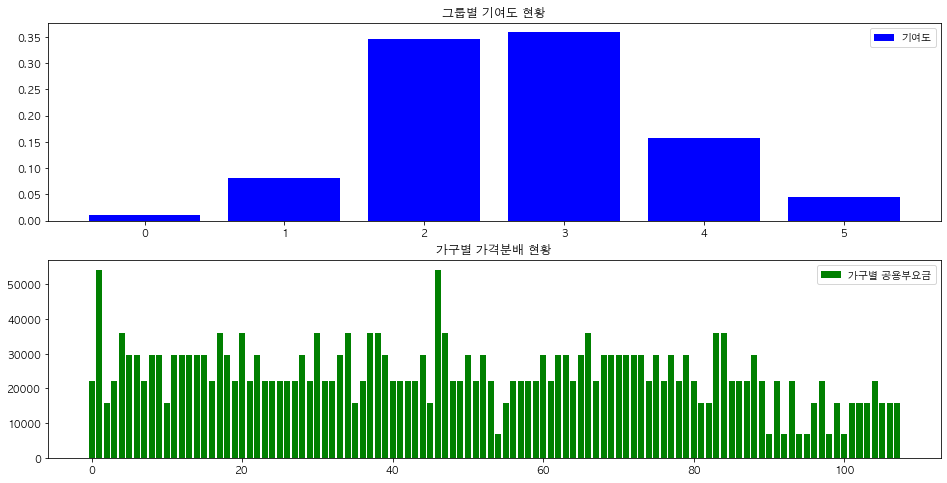

In [262]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(dist_1_1)), dist_2['contribution'], color='b', label='기여도')
ax_1.set_title("그룹별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), dist_cont_2['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [263]:
min_h = dist_cont_2[dist_cont_2['name'] == '아파트1-104-905']
mean_h = dist_cont_2[dist_cont_2['name'] == '아파트1-102-801']
max_h = dist_cont_2[dist_cont_2['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,기여도 공용부 요금,공용부 요금 나머지,최종 공용부 요금
107,아파트1-104-905,148,1,12310,3604,15914
43,아파트1-102-801,280,2,18557,3604,22161
46,아파트1-102-903,711,6,50667,3604,54271


# 기여도를 적용비율로 이용

In [272]:
col_df = hist_df

col_df['공용부 기본요금'] = round(pp.basic / len(month_df)) * col_df['가구 수']
col_df['공용부 전력량요금'] = round(pp.elec_rate / len(month_df)) * col_df['가구 수']

col_df

,start,end,가구 수,median,수거 필요액수,공용부 기본요금,공용부 전력량요금
0,10.000000,110.142857,7.0,60.071429,171150.0,29764.0,116158.0
1,110.142857,210.285714,15.0,160.214286,366750.0,63780.0,248910.0
2,210.285714,310.428571,42.0,260.357143,1026900.0,178584.0,696948.0
3,310.428571,410.571429,31.0,360.500000,757950.0,131812.0,514414.0
4,410.571429,510.714286,11.0,460.642857,268950.0,46772.0,182534.0
5,510.714286,610.857143,0.0,560.785714,0.0,0.0,0.0
6,610.857143,711.000000,2.0,660.928571,48900.0,8504.0,33188.0


In [287]:
col_df = col_df[col_df['가구 수'] > 0]
col_df

,start,end,가구 수,median,수거 필요액수,공용부 기본요금,공용부 전력량요금
0,10.000000,110.142857,7.0,60.071429,171150.0,29764.0,116158.0
1,110.142857,210.285714,15.0,160.214286,366750.0,63780.0,248910.0
2,210.285714,310.428571,42.0,260.357143,1026900.0,178584.0,696948.0
3,310.428571,410.571429,31.0,360.500000,757950.0,131812.0,514414.0
4,410.571429,510.714286,11.0,460.642857,268950.0,46772.0,182534.0
6,610.857143,711.000000,2.0,660.928571,48900.0,8504.0,33188.0


## 그룹의 중간값을 이용한 기여도 산정

### 그룹의 중간값들의 토탈과 비교하여 기여도 산정

In [307]:
norm_hist_1_1 = hist_df_1_1[hist_df_1_1['가구 수'] > 0].copy()
# norm_hist_1_1['contribution'] = (norm_hist_1_1['contribution'] - norm_hist_1_1['contribution'].min()) /\
#                 (norm_hist_1_1['contribution'].max() - norm_hist_1_1['contribution'].min())

norm_hist_1_1['기여도 공용부 기본요금'] = (col_df['공용부 기본요금'] * norm_hist_1_1['contribution']).round().astype("int")
norm_hist_1_1['기여도 공용부 전력량요금'] = (col_df['공용부 전력량요금'] * norm_hist_1_1['contribution']).round().astype("int")

norm_hist_1_1['기여도 공용부 요금'] = norm_hist_1_1['기여도 공용부 기본요금'] + norm_hist_1_1['기여도 공용부 전력량요금']
norm_hist_1_1['가구 별 분배가격'] = (norm_hist_1_1['기여도 공용부 요금'] / norm_hist_1_1['가구 수']).round().astype("int")
norm_hist_1_1

,start,end,가구 수,median,contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부 요금,가구 별 분배가격
0,10.000000,110.142857,7.0,60.071429,0.023805,709,2765,3474,496
1,110.142857,210.285714,15.0,160.214286,0.063489,4049,15803,19852,1323
2,210.285714,310.428571,42.0,260.357143,0.103173,18425,71906,90331,2151
3,310.428571,410.571429,31.0,360.500000,0.142857,18830,73488,92318,2978
4,410.571429,510.714286,11.0,460.642857,0.182541,8538,33320,41858,3805
6,610.857143,711.000000,2.0,660.928571,0.261909,2227,8692,10919,5460


In [308]:
norm_cont_1_1 = month_df.copy()
norm_cont_1_1['기여도 공용부 요금'] = 0

for idx, row in norm_hist_1_1.iterrows():
    public_fee = row['가구 별 분배가격']
    norm_cont_1_1['기여도 공용부 요금'][norm_cont_1_1['그룹 번호'] == idx] = public_fee
    
norm_cont_1_1['공용부 요금 나머지'] = round((public_bill - norm_cont_1_1['기여도 공용부 요금'].sum()) / len(norm_cont_1_1))
norm_cont_1_1['최종 공용부 요금'] = norm_cont_1_1['기여도 공용부 요금'] + norm_cont_1_1['공용부 요금 나머지']
    
norm_cont_1_1.head(10)

,name,usage (kWh),그룹 번호,기여도 공용부 요금,공용부 요금 나머지,최종 공용부 요금
0,아파트1-101-1002,253,2,2151,22054,24205
1,아파트1-101-104,689,6,5460,22054,27514
2,아파트1-101-1102,183,1,1323,22054,23377
3,아파트1-101-1202,239,2,2151,22054,24205
4,아파트1-101-1302,455,4,3805,22054,25859
5,아파트1-101-1401,343,3,2978,22054,25032
6,아파트1-101-1403,380,3,2978,22054,25032
7,아파트1-101-1502,219,2,2151,22054,24205
8,아파트1-101-1504,389,3,2978,22054,25032
9,아파트1-101-1602,350,3,2978,22054,25032


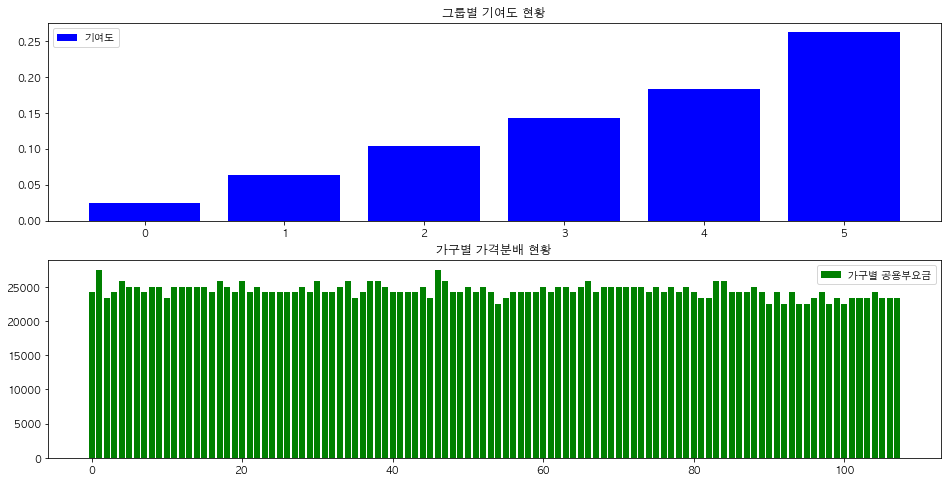

In [309]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(dist_1_1)), norm_hist_1_1['contribution'], color='b', label='기여도')
ax_1.set_title("그룹별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), norm_cont_1_1['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [310]:
min_h = norm_cont_1_1[norm_cont_1_1['name'] == '아파트1-104-905']
mean_h = norm_cont_1_1[norm_cont_1_1['name'] == '아파트1-102-801']
max_h = norm_cont_1_1[norm_cont_1_1['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,기여도 공용부 요금,공용부 요금 나머지,최종 공용부 요금
107,아파트1-104-905,148,1,1323,22054,23377
43,아파트1-102-801,280,2,2151,22054,24205
46,아파트1-102-903,711,6,5460,22054,27514


### 세대부 총 사용량과 비교하여 기여도 산정

In [336]:
norm_cont_1_2 = cont_df_1_2.copy()
norm_cont_1_2['contribution'] = (norm_cont_1_2['contribution'] - norm_cont_1_2['contribution'].min()) / \
                (norm_cont_1_2['contribution'].max() - norm_cont_1_2['contribution'].min())

norm_cont_1_2

,name,usage (kWh),그룹 번호,contribution
0,아파트1-101-1002,253,2,0.333333
1,아파트1-101-104,689,6,1.000000
2,아파트1-101-1102,183,1,0.166667
3,아파트1-101-1202,239,2,0.333333
4,아파트1-101-1302,455,4,0.666667
...,...,...,...,...
103,아파트1-104-606,180,1,0.166667
104,아파트1-104-705,290,2,0.333333
105,아파트1-104-708,184,1,0.166667
106,아파트1-104-902,176,1,0.166667


In [337]:
norm_cont_1_2 = norm_cont_1_2.copy()

norm_cont_1_2['기여도 공용부 기본요금'] = round(pp.basic / len(month_df) * norm_cont_1_2['contribution']).astype("int")
norm_cont_1_2['기여도 공용부 전력량요금'] = round(pp.elec_rate / len(month_df) * norm_cont_1_2['contribution']).astype("int")
norm_cont_1_2['기여도 공용부 요금'] = norm_cont_1_2['기여도 공용부 기본요금'] + norm_cont_1_2['기여도 공용부 전력량요금']
norm_cont_1_2['공용부 요금 나머지'] = round((public_bill - norm_cont_1_2['기여도 공용부 요금'].sum()) / len(month_df))
norm_cont_1_2['최종 공용부 요금'] = norm_cont_1_2['기여도 공용부 요금'] + norm_cont_1_2['공용부 요금 나머지']

norm_cont_1_2.head(10)

,name,usage (kWh),그룹 번호,contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부 요금,공용부 요금 나머지,최종 공용부 요금
0,아파트1-101-1002,253,2,0.333333,1417,5531,6948,16472,23420
1,아파트1-101-104,689,6,1.000000,4252,16594,20846,16472,37318
2,아파트1-101-1102,183,1,0.166667,709,2766,3475,16472,19947
3,아파트1-101-1202,239,2,0.333333,1417,5531,6948,16472,23420
4,아파트1-101-1302,455,4,0.666667,2835,11063,13898,16472,30370
5,아파트1-101-1401,343,3,0.500000,2126,8297,10423,16472,26895
6,아파트1-101-1403,380,3,0.500000,2126,8297,10423,16472,26895
7,아파트1-101-1502,219,2,0.333333,1417,5531,6948,16472,23420
8,아파트1-101-1504,389,3,0.500000,2126,8297,10423,16472,26895
9,아파트1-101-1602,350,3,0.500000,2126,8297,10423,16472,26895


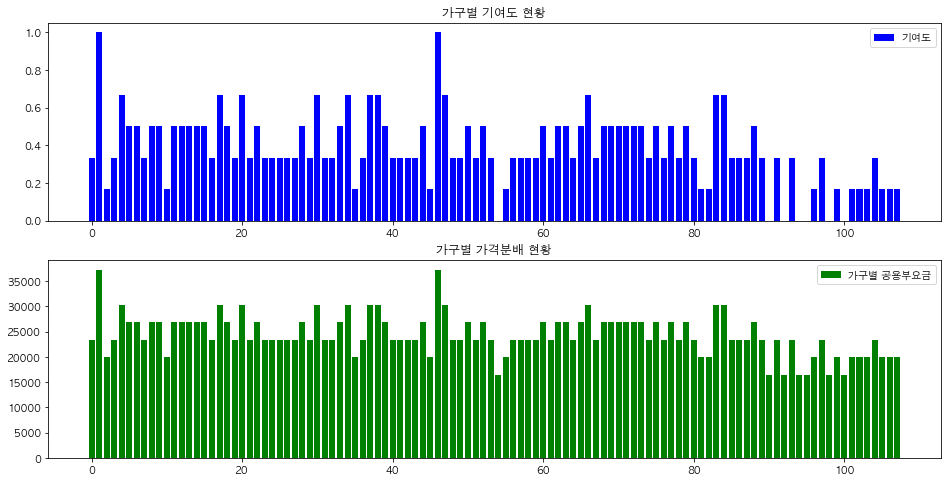

In [338]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(month_df)), norm_cont_1_2['contribution'], color='b', label='기여도')
ax_1.set_title("가구별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), norm_cont_1_2['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [339]:
min_h = norm_cont_1_2[norm_cont_1_2['name'] == '아파트1-104-905']
mean_h = norm_cont_1_2[norm_cont_1_2['name'] == '아파트1-102-801']
max_h = norm_cont_1_2[norm_cont_1_2['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,contribution,기여도 공용부 기본요금,기여도 공용부 전력량요금,기여도 공용부 요금,공용부 요금 나머지,최종 공용부 요금
107,아파트1-104-905,148,1,0.166667,709,2766,3475,16472,19947
43,아파트1-102-801,280,2,0.333333,1417,5531,6948,16472,23420
46,아파트1-102-903,711,6,1.000000,4252,16594,20846,16472,37318


## 그룹안에 속해있는 가구들의 사용량 총합으로 기여도 산정

In [341]:
norm_hist_2 = cont_df_2[cont_df_2['가구 수'] > 0].copy()
norm_hist_2['개별 기여도'] = norm_hist_2['contribution'] / norm_hist_2['가구 수']
norm_hist_2['개별 기여도'] = (norm_hist_2['개별 기여도'] - norm_hist_2['개별 기여도'].min()) / \
                (norm_hist_2['개별 기여도'].max() - norm_hist_2['개별 기여도'].min())

norm_hist_2['기여도 공용부 기본요금 (가구 별)'] = round(pp.basic / len(month_df) * norm_hist_2['개별 기여도'])
norm_hist_2['기여도 공용부 전력량요금 (가구 별)'] = round(pp.elec_rate / len(month_df) * norm_hist_2['개별 기여도'])
norm_hist_2['기여도 공용부 요금 (가구 별)'] = norm_hist_2['기여도 공용부 기본요금 (가구 별)'] + norm_hist_2['기여도 공용부 전력량요금 (가구 별)']

norm_hist_2

,start,end,가구 수,median,사용량 총 합,contribution,개별 기여도,기여도 공용부 기본요금 (가구 별),기여도 공용부 전력량요금 (가구 별),기여도 공용부 요금 (가구 별)
0,10.000000,110.142857,7.0,60.071429,315,0.010127,0.000000,0.0,0.0,0.0
1,110.142857,210.285714,15.0,160.214286,2551,0.082015,0.190941,812.0,3169.0,3981.0
2,210.285714,310.428571,42.0,260.357143,10768,0.346193,0.322719,1372.0,5355.0,6727.0
3,310.428571,410.571429,31.0,360.500000,11154,0.358603,0.480621,2043.0,7976.0,10019.0
4,410.571429,510.714286,11.0,460.642857,4916,0.158050,0.613602,2609.0,10182.0,12791.0
6,610.857143,711.000000,2.0,660.928571,1400,0.045010,1.000000,4252.0,16594.0,20846.0


In [342]:
norm_cont_2 = cont_df.copy()
norm_cont_2['기여도 공용부 요금'] = 0

for idx, row in norm_hist_2.iterrows():
    public_fee = row['기여도 공용부 요금 (가구 별)']
    norm_cont_2['기여도 공용부 요금'][norm_cont_2['그룹 번호'] == idx] = public_fee
    
norm_cont_2['공용부 요금 나머지'] = round((public_bill - norm_cont_2['기여도 공용부 요금'].sum()) / len(month_df))
norm_cont_2['최종 공용부 요금'] = norm_cont_2['기여도 공용부 요금'] + norm_cont_2['공용부 요금 나머지']

norm_cont_2.head(10)

,name,usage (kWh),그룹 번호,기여도 공용부 요금,공용부 요금 나머지,최종 공용부 요금
0,아파트1-101-1002,253,2,6727,16716,23443
1,아파트1-101-104,689,6,20846,16716,37562
2,아파트1-101-1102,183,1,3981,16716,20697
3,아파트1-101-1202,239,2,6727,16716,23443
4,아파트1-101-1302,455,4,12791,16716,29507
5,아파트1-101-1401,343,3,10019,16716,26735
6,아파트1-101-1403,380,3,10019,16716,26735
7,아파트1-101-1502,219,2,6727,16716,23443
8,아파트1-101-1504,389,3,10019,16716,26735
9,아파트1-101-1602,350,3,10019,16716,26735


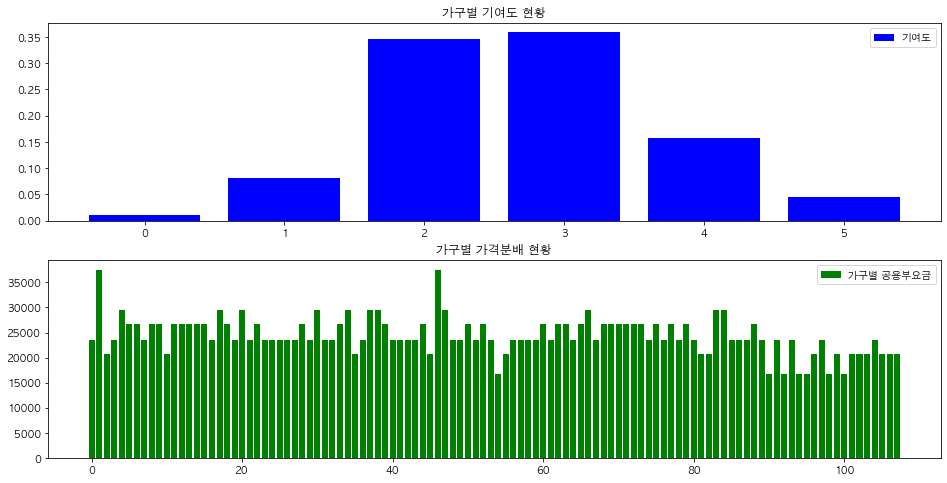

In [343]:
plt.figure(figsize=(16,8))

ax_1 = plt.subplot(2,1,1)
ax_1.bar(range(len(norm_hist_2)), norm_hist_2['contribution'], color='b', label='기여도')
ax_1.set_title("가구별 기여도 현황")
ax_1.legend()

ax_2 = plt.subplot(2,1,2)
ax_2.bar(range(len(month_df)), norm_cont_2['최종 공용부 요금'], color='g', label='가구별 공용부요금')
ax_2.set_title("가구별 가격분배 현황")
ax_2.legend()

plt.show()

In [344]:
min_h = norm_cont_2[norm_cont_2['name'] == '아파트1-104-905']
mean_h = norm_cont_2[norm_cont_2['name'] == '아파트1-102-801']
max_h = norm_cont_2[norm_cont_2['name'] == '아파트1-102-903']

problem_simple_cont = pd.concat([min_h, mean_h, max_h])
problem_simple_cont

,name,usage (kWh),그룹 번호,기여도 공용부 요금,공용부 요금 나머지,최종 공용부 요금
107,아파트1-104-905,148,1,3981,16716,20697
43,아파트1-102-801,280,2,6727,16716,23443
46,아파트1-102-903,711,6,20846,16716,37562
